In [1]:
!python3 data_processing.py

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
"""
Data Folder for YOLOv5 tests
"""
data_folder = "./data-cxywh"


### Get Data

In [4]:
def filter_images_with_labels(image_files, data_folder):
    """Filters image files to include only those with corresponding label files."""
    valid_images = []
    for img_file in image_files:
        label_file = img_file.replace(".jpg", ".txt")
        if os.path.exists(os.path.join(data_folder, label_file)):
            valid_images.append((img_file, label_file))
    return valid_images

image_files = [f for f in os.listdir(data_folder) if f.endswith(".jpg")]
filtered_images = filter_images_with_labels(image_files, data_folder)

### Data Analysis

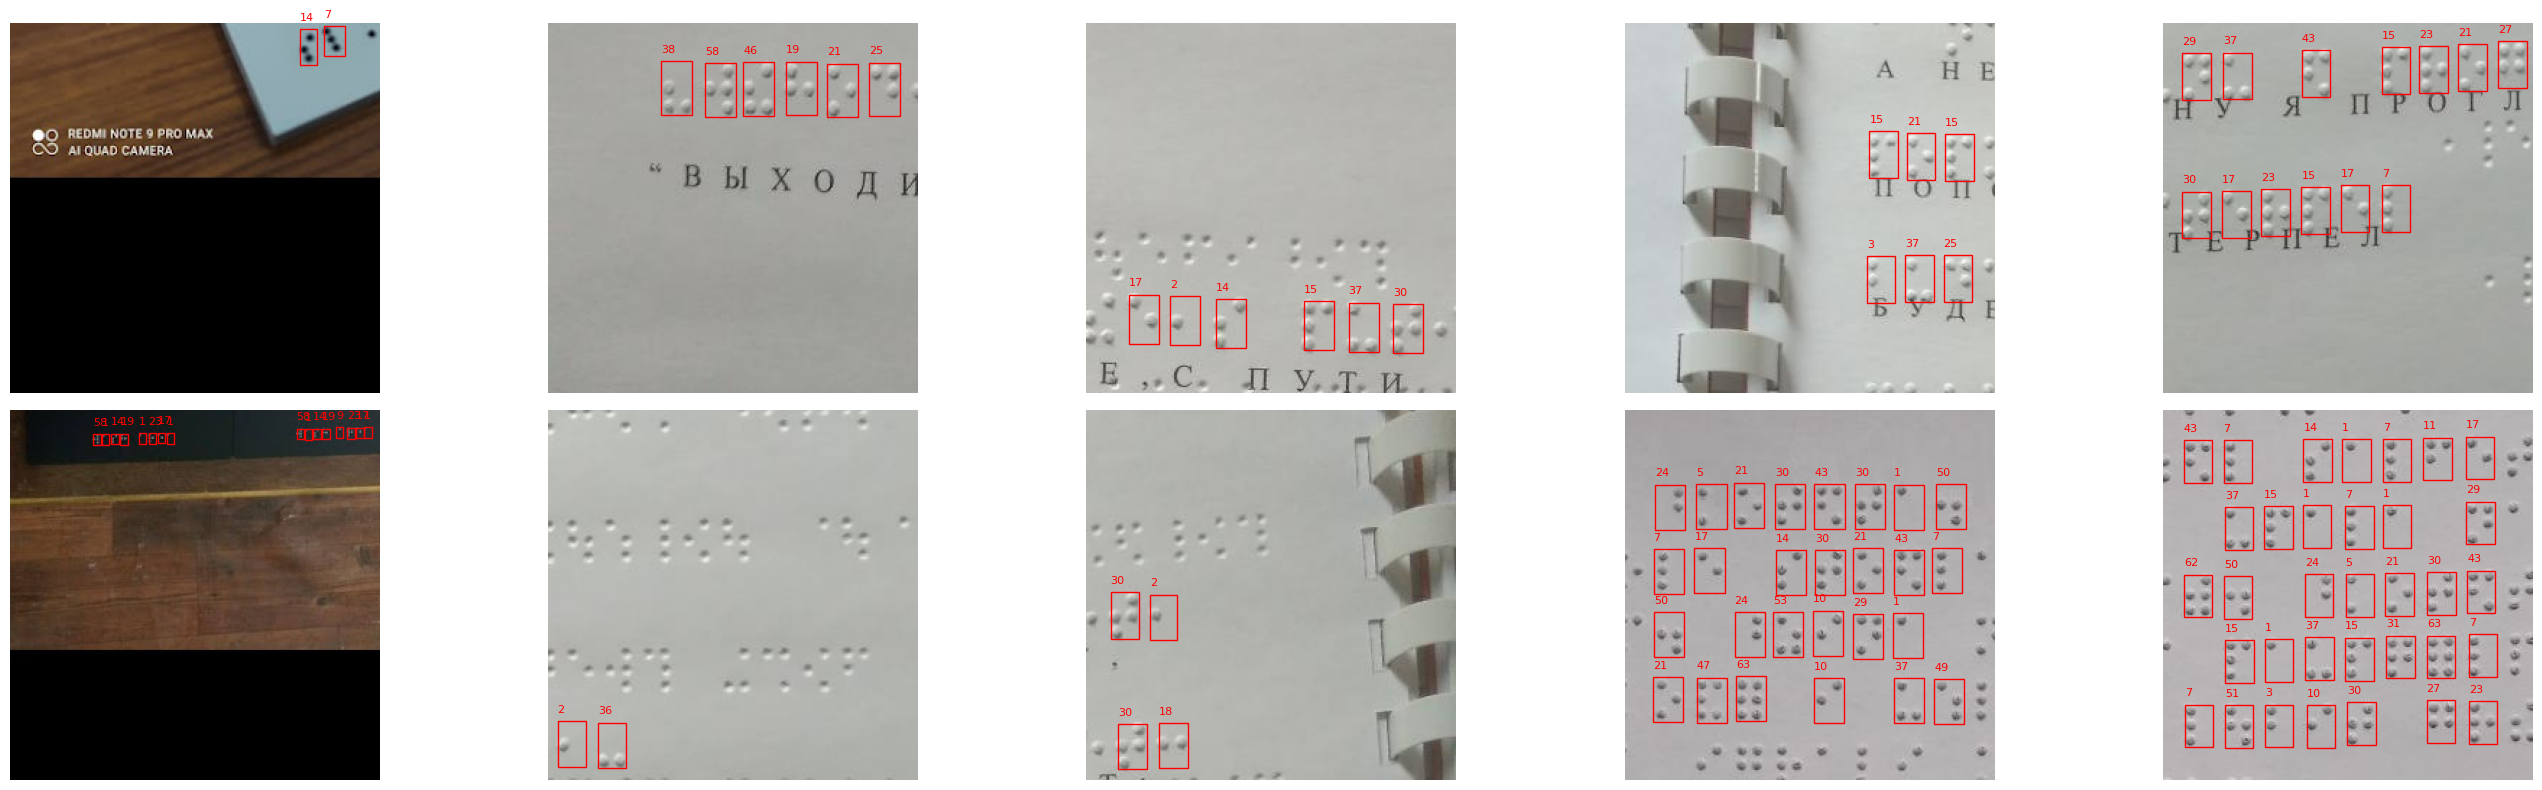

In [5]:
random_images = random.sample(filtered_images, min(10, len(filtered_images)))

def plot_annotated_images(image_files):
    fig, axs = plt.subplots(2, 5, figsize=(28, 8))
    axs = axs.flatten()

    for idx, (img_file, lbl_file) in enumerate(image_files):
        img_path = os.path.join(data_folder, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        
        with open(os.path.join(data_folder, lbl_file), "r") as f:
            boxes = f.readlines()
        
        axs[idx].imshow(img)
        for box in boxes:
            class_id, x_center, y_center, box_width, box_height = map(float, box.strip().split())
            x_center *= width
            y_center *= height
            box_width *= width
            box_height *= height
            x_min = x_center - box_width / 2
            y_min = y_center - box_height / 2
            
            axs[idx].add_patch(plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor='red', facecolor='none'))
            axs[idx].text(x_min, y_min - 5, f"{int(class_id) + 1}", color='red', fontsize=8, verticalalignment='bottom')

        axs[idx].axis("off")

    for j in range(idx + 1, 10):
        axs[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_annotated_images(random_images)


In [6]:
freq_label = {}

for idx, (_, lbl_file) in enumerate(filtered_images):
    with open(os.path.join(data_folder, lbl_file), 'r') as label:
        labels = label.readlines()
        
    labels = [int(l.strip().split()[0]) for l in labels]
    for label in labels:
        if label in freq_label:
            freq_label[label] += 1
        else:
            freq_label[label] = 1

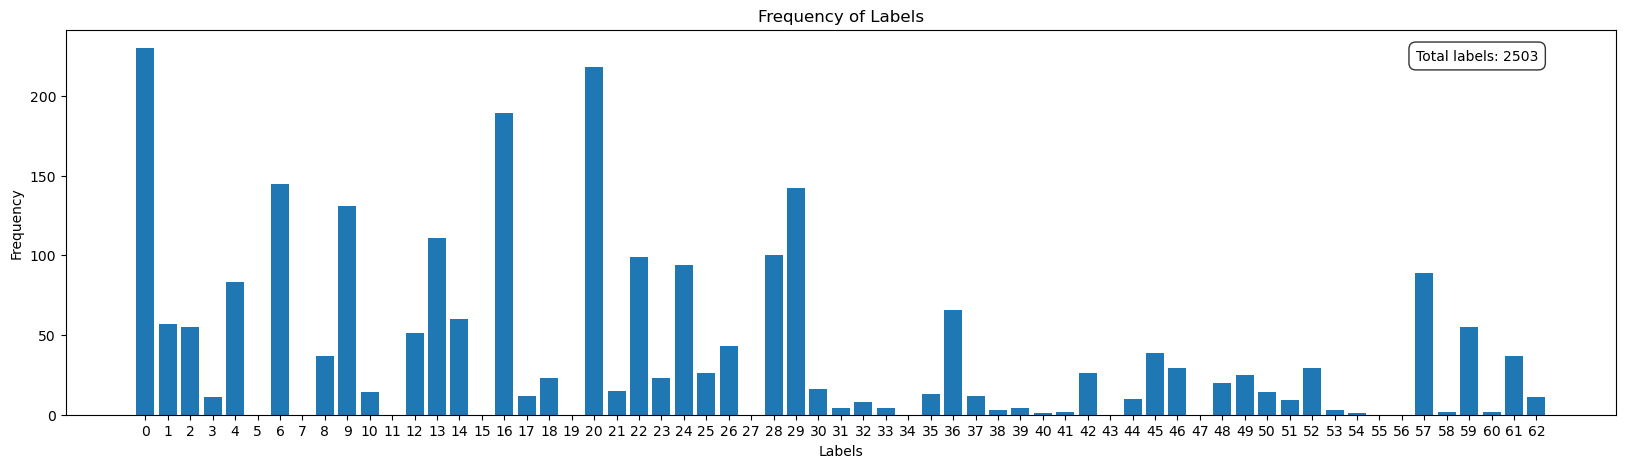

In [7]:
from typing import Dict

def plot_freq_map(freq_map:Dict, x_label:str='Labels', y_label:str='Frequency', title:str='Frequency of Labels'):
    keys = sorted(freq_map.keys())
    values = [freq_map[key] for key in keys]
    total = sum(values)
    
    plt.figure(figsize=(20, 5))
    plt.bar(keys, values)
    plt.xticks(range(min(keys), max(keys) + 1))
    plt.gca().text(0.95, 0.95, f'Total labels: {total}', ha='right', va='top', transform=plt.gca().transAxes,
                   bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    plt.show()

plot_freq_map(freq_map=freq_label)

### YOLOv5 Only

<img src="yolov5-model-structure.avif" alt="YOLOv5 Model Structure" width="50%">

train, test, validation split: 60, 20, 20

In [8]:
from ultralytics import YOLO
import shutil
from sklearn.model_selection import train_test_split

NUM_EPOCHS_YOLO = 1
BATCH_SIZE_YOLO = 18

yolo_data_folder = './yolo-data'
os.makedirs(yolo_data_folder, exist_ok=True)

model = YOLO('yolov5s.pt')

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [9]:
train_images, temp_images = train_test_split(filtered_images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

os.makedirs(os.path.join(yolo_data_folder, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'val', 'labels'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_folder, 'test', 'labels'), exist_ok=True)

for img_file, label_file in train_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'train', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'train', 'labels'))

for img_file, label_file in val_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'val', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'val', 'labels'))

for img_file, label_file in test_images:
    shutil.copy(os.path.join(data_folder, img_file), os.path.join(yolo_data_folder, 'test', 'images'))
    shutil.copy(os.path.join(data_folder, label_file), os.path.join(yolo_data_folder, 'test', 'labels'))

In [10]:
if os.path.exists('./runs'):
    shutil.rmtree('./runs')
history = model.train(data='yolo.yaml', epochs=NUM_EPOCHS_YOLO, batch=BATCH_SIZE_YOLO)

Ultralytics 8.3.28 🚀 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=yolo.yaml, epochs=1, time=None, patience=100, batch=18, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

train: Scanning /home/zeenx1popos/Documents/codes/fyb/yolo-data/train/labels.cache... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/home/zeenx1popos/.conda/envs/fybp/lib/python3.12/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error _ssl.c:983: The handshake operation timed out>
  data = fetch_version_info()
val: Scanning /home/zeenx1popos/Documents/codes/fyb/yolo-data/val/labels.cache... 66 images, 0 backgrounds, 0 corrupt: 100%|██████████| 66/66 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000149, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005625000000000001), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1       4.6G      3.046      6.004       2.18        126        640: 100%|██████████| 10/10 [00:03<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


                   all         66        940   0.000111    0.00208    6.4e-05   3.07e-05

1 epochs completed in 0.002 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.12.2 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5931MiB)
YOLOv5s summary (fused): 193 layers, 9,135,917 parameters, 0 gradients, 24.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


                   all         66        940    7.6e-05    0.00141   4.48e-05    2.5e-05
                     1         41         99          0          0          0          0
                     2         16         23          0          0          0          0
                     3         16         19          0          0          0          0
                     5         22         27          0          0          0          0
                     7         29         50          0          0          0          0
                     9         11         12          0          0          0          0
                    10         28         50          0          0          0          0
                    11          3          3          0          0          0          0
                    13         16         20          0          0          0          0
                    14         24         42          0          0          0          0
                    1

#### Training and Validation Loss

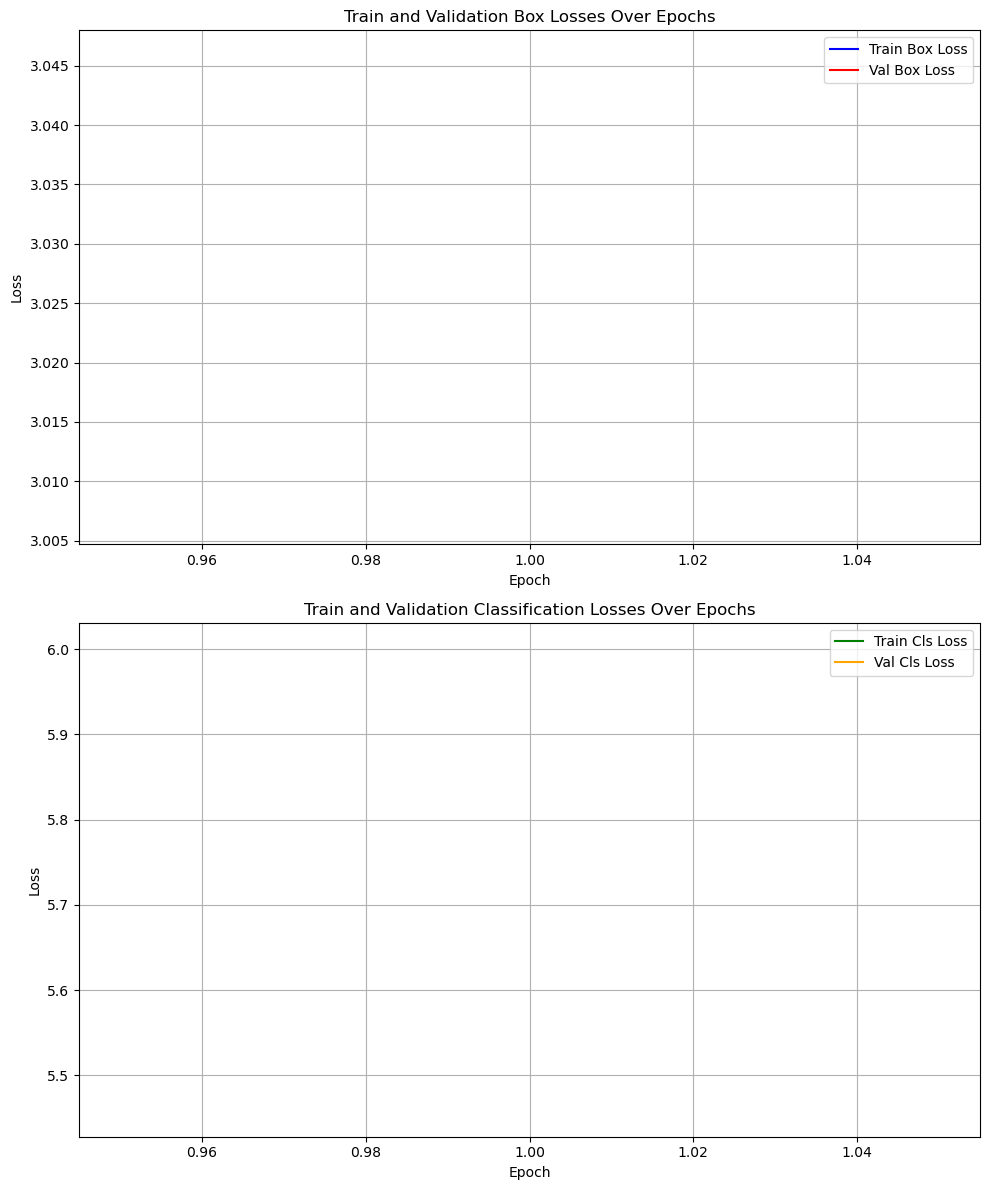

In [11]:
YOLO_RESULTS_FOLDER = './runs/detect/train'

import pandas as pd

df = pd.read_csv(os.path.join(YOLO_RESULTS_FOLDER, 'results.csv'))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

ax1.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='blue')
ax1.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Validation Box Losses Over Epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='green')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='orange')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Train and Validation Classification Losses Over Epochs')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [12]:
test_images_path = os.path.join(yolo_data_folder, 'test', 'images')

model_weights = os.path.join(YOLO_RESULTS_FOLDER, 'weights/best.pt')
trained_model = YOLO(model_weights)



image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190821_123648.labeled_512_0.jpg: 640x640 (no detections), 7.6ms
Speed: 2.4ms preprocess, 7.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


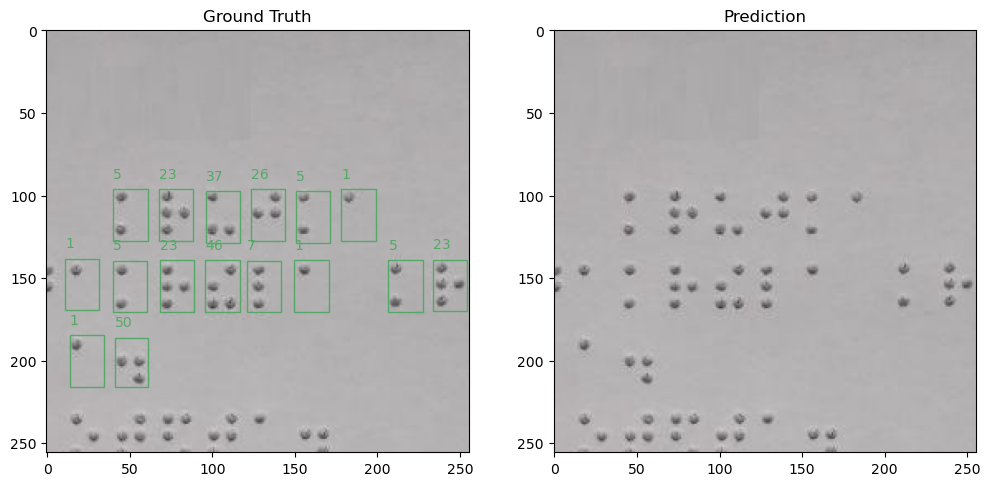


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113013.labeled_0_0.jpg: 640x640 (no detections), 6.7ms
Speed: 1.7ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


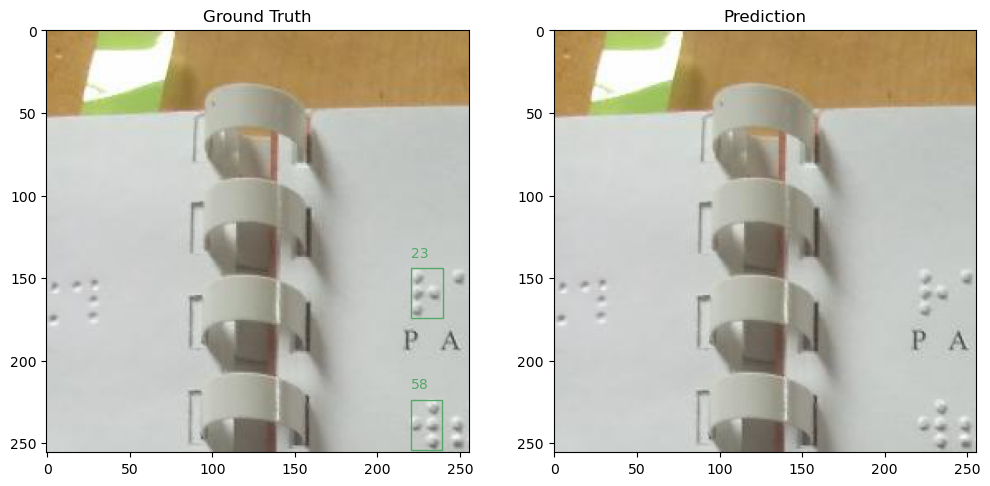


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113010.labeled_0_768.jpg: 640x640 (no detections), 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


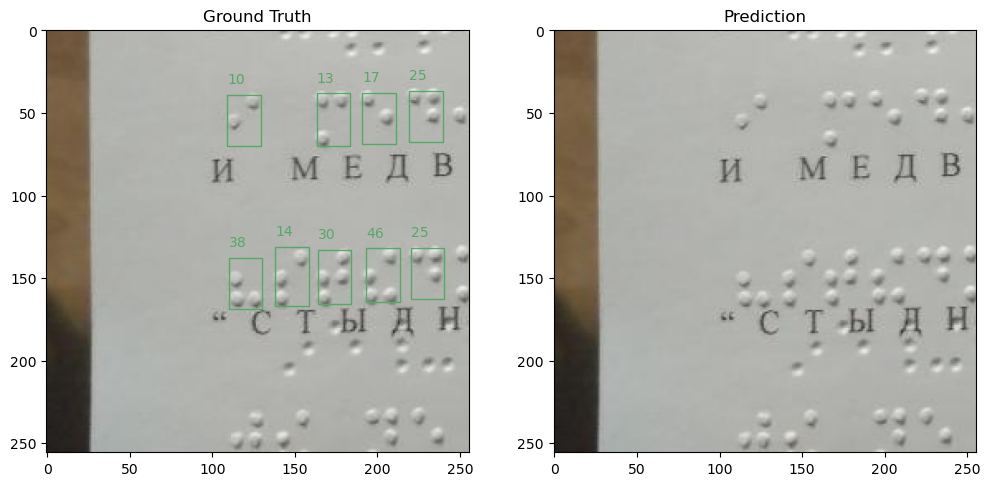


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_112947.labeled_256_0.jpg: 640x640 (no detections), 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


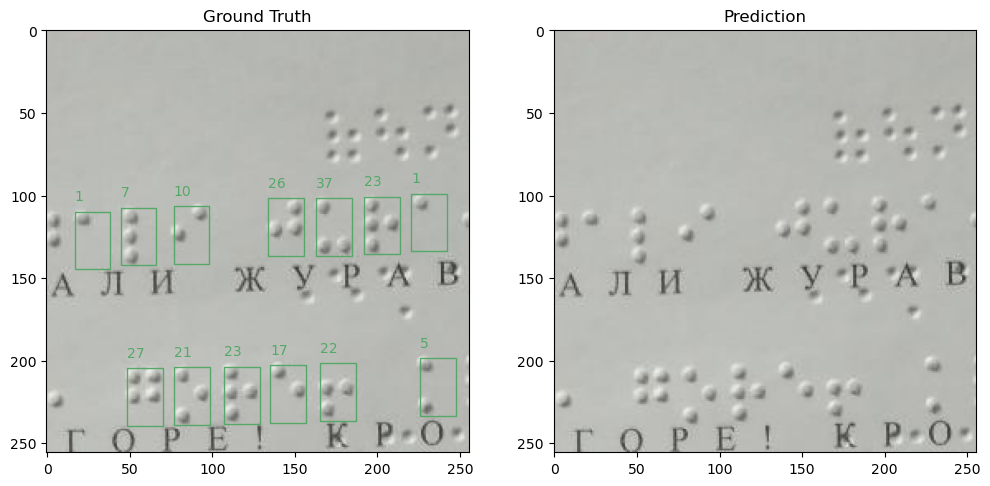


image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113023.labeled_0_512.jpg: 640x640 (no detections), 6.3ms
Speed: 1.4ms preprocess, 6.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


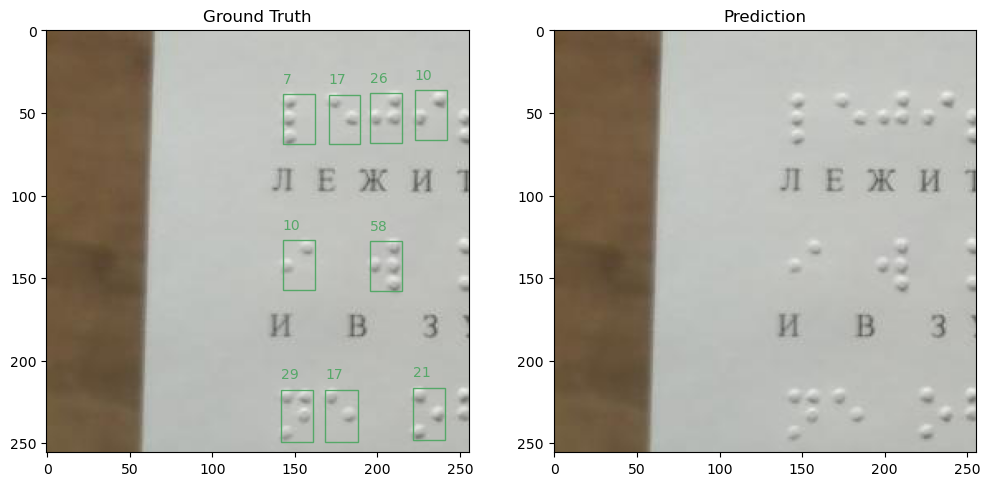

In [13]:
from random import choice

def plot_annotated_images_with_predictions(test_images, trained_model):
    img_file, lbl_file = choice(test_images)
    img_file = os.path.join(yolo_data_folder, 'test', 'images', img_file)
    lbl_file = os.path.join(yolo_data_folder, 'test', 'labels', lbl_file)
    
    img = cv2.imread(img_file)
    
    if img is None:
        print(f"Error: Could not load image {img_file}")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape
    
    with open(lbl_file, "r") as f:
        ground_truth_boxes = f.readlines()
    
    results = trained_model(img_file)
    predictions = results[0].boxes.xywh.cpu().numpy()
    confidences = results[0].boxes.conf.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img_rgb)
    ax1.set_title("Ground Truth")
    
    for gt_box in ground_truth_boxes:
        class_id, x_center, y_center, box_width, box_height = map(float, gt_box.strip().split())
        x_center *= width
        y_center *= height
        box_width *= width
        box_height *= height
        x_min = x_center - box_width / 2
        y_min = y_center - box_height / 2
        ax1.add_patch(plt.Rectangle((x_min, y_min), box_width, box_height, edgecolor='g', facecolor='none'))
        ax1.text(x_min, y_min - 5, f"{int(class_id) + 1}", color='g', fontsize=10, verticalalignment='bottom')
    
    ax2.imshow(img_rgb)
    ax2.set_title("Prediction")
    
    for pred_box, confidence, class_id in zip(predictions, confidences, class_ids):
        x_center, y_center, width_pred, height_pred = pred_box
        
        x_min = x_center - width_pred / 2
        y_min = y_center - height_pred / 2
        
        ax2.add_patch(plt.Rectangle((x_min, y_min), width_pred, height_pred, edgecolor='r', facecolor='none'))
        ax2.text(x_min, y_min - 5, f"{int(class_id) + 1}\n({confidence:.2f})", color='r', fontsize=8, verticalalignment='bottom')
    
    plt.show()

    
for _ in range(5):
    plot_annotated_images_with_predictions(test_images, trained_model)

In [14]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def iou_score(box_a, box_b):
    """Calculate Intersection over Union (IoU) between two bounding boxes."""
    x_min_a, y_min_a, width_a, height_a = box_a
    x_min_b, y_min_b, width_b, height_b = box_b

    x_max_a, y_max_a = x_min_a + width_a, y_min_a + height_a
    x_max_b, y_max_b = x_min_b + width_b, y_min_b + height_b

    inter_x_min = max(x_min_a, x_min_b)
    inter_y_min = max(y_min_a, y_min_b)
    inter_x_max = min(x_max_a, x_max_b)
    inter_y_max = min(y_max_a, y_max_b)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
    area_a = width_a * height_a
    area_b = width_b * height_b

    union_area = area_a + area_b - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def evaluate_model(test_images, trained_model, iou_threshold=0.5):
    ious, y_true, y_pred = [], [], []

    for img_file, lbl_file in test_images:
        img_path = os.path.join(yolo_data_folder, 'test', 'images', img_file)
        lbl_path = os.path.join(yolo_data_folder, 'test', 'labels', lbl_file)
        
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Error: Could not load image {img_path}")
            return
        
        height, width, _ = img.shape
        
        with open(lbl_path, "r") as f:
            ground_truth_boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        
        results = trained_model(img_path)
        predictions = results[0].boxes.xywh.cpu().numpy()
        pred_classes = results[0].boxes.cls.cpu().numpy()
        
        for gt_class, x_center, y_center, box_width, box_height in ground_truth_boxes:
            x_center *= width
            y_center *= height
            box_width *= width
            box_height *= height
            gt_box = [(x_center - box_width / 2), (y_center - box_height / 2), box_width, box_height]
            max_iou, matched_pred_class = 0, -1
            
            for pred_box, pred_class in zip(predictions, pred_classes):
                x_center, y_center, width_pred, height_pred = pred_box
                
                x_min = x_center - width_pred / 2
                y_min = y_center - height_pred / 2
                
                pred_box = [x_min, y_min, width_pred, height_pred]
                
                iou = iou_score(gt_box, pred_box)
                if iou > max_iou:
                    max_iou = iou
                    matched_pred_class = int(pred_class)
            
            ious.append(max_iou)
            y_true.append(int(gt_class))
            y_pred.append(matched_pred_class if max_iou >= iou_threshold else -1)
    
    ious = np.array(ious)
    avg_iou = np.mean(ious)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return {
        'avg_iou': avg_iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

metrics = evaluate_model(test_images, trained_model)



image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG-20210928-WA0005_0_0.jpg: 640x640 (no detections), 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190822_182350.labeled_0_256.jpg: 640x640 (no detections), 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_112947.labeled_256_0.jpg: 640x640 (no detections), 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/test/images/IMG_20190715_113026.labeled_256_256.jpg: 640x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/zeenx1popos/Documents/codes/fyb/yolo-data/t

#### Evaluation

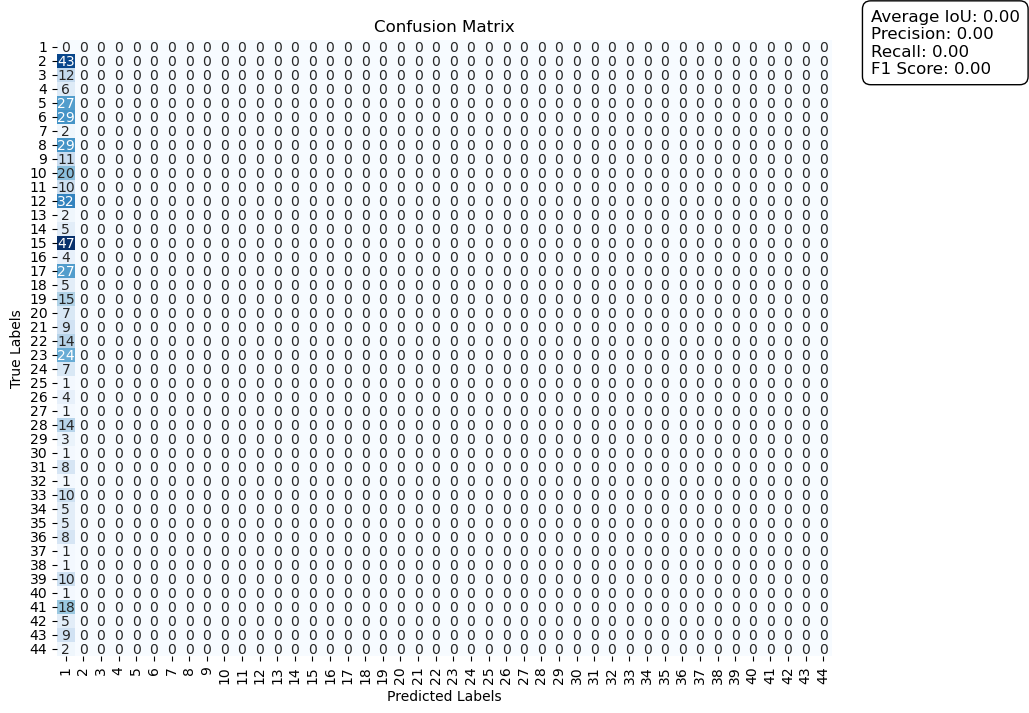

In [15]:
def plot_confusion_matrix(conf_matrix, class_names, metrics):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    
    metrics_text = (
        f"Average IoU: {metrics['avg_iou']:.2f}\n"
        f"Precision: {metrics['precision']:.2f}\n"
        f"Recall: {metrics['recall']:.2f}\n"
        f"F1 Score: {metrics['f1_score']:.2f}"
    )
    
    plt.gca().text(1.05, 1.05, metrics_text, transform=plt.gca().transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    plt.show()

class_names = [f"{i + 1}" for i in range(len(metrics['confusion_matrix']))]
plot_confusion_matrix(metrics['confusion_matrix'], class_names, metrics)

del trained_model

# MODEL STARTS HERE

In [ ]:
import os
import random
import shutil
import cv2

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from typing import Dict

from ultralytics import YOLO

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = torch.device("cpu")

### HOUGH TRANSFORM

In [16]:
def HoughTransform(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 3
    )
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    processed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image = np.full_like(gray, 50)
    
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # Set minimum and maximum size thresholds for Braille dots
        if 3 <= w <= 7 and 3 <= h <= 7:  # Size range for Braille dots
            area = cv2.contourArea(contour)
            if area < 50:
                confidence_intensity = int(255 - (area / 50) * 205)  # From 50 (low confidence) to 255 (high confidence)
                cv2.drawContours(output_image, [contour], -1, confidence_intensity, thickness=cv2.FILLED)
    
    return gray, blurred, thresh, processed, output_image

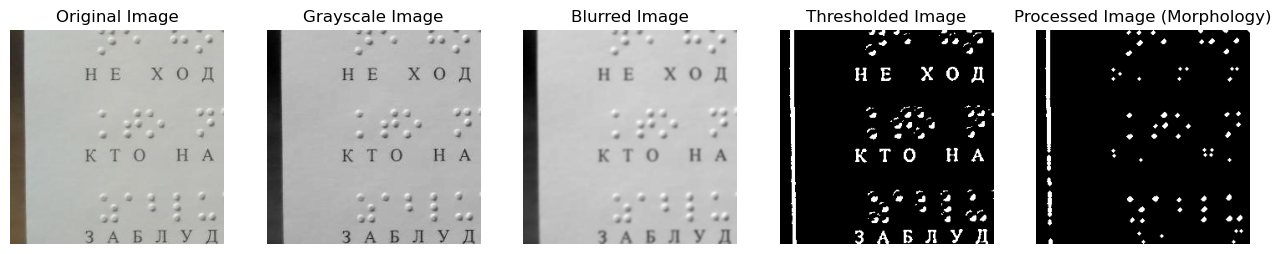

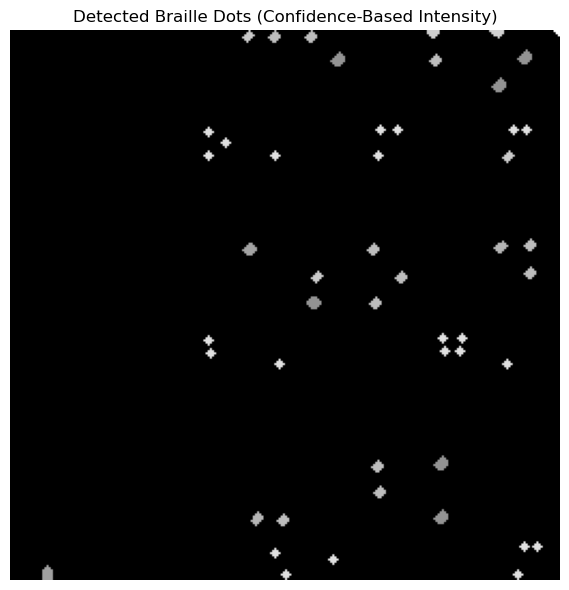

In [17]:
"""
TEST HOUGH TRANSFORM
"""
def test_hough_transform(image_path):
    test_image = cv2.imread(image_path)
    
    gray, blurred, thresh, processed, output_image = HoughTransform(test_image)
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(thresh, cmap='gray')
    plt.title("Thresholded Image")
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(processed, cmap='gray')
    plt.title("Processed Image (Morphology)")
    plt.axis('off')
    
    plt.figure(figsize=(6, 6))
    plt.imshow(output_image, cmap='gray')
    plt.title("Detected Braille Dots (Confidence-Based Intensity)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


"""
TEST
"""
test_hough_transform(os.path.join(data_folder, 'IMG_20190715_112947.labeled_0_512.jpg'))

## BRAILLE SPOTTING MODEL

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = torch.device("cpu")

In [19]:
"""
Testing Models:
"""
def test_conv_block(model, skip=False, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    layer2 = None
    if skip:
        layer2 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)

class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels=3, skip=False) -> None:
        super(ConvolutionBlock, self).__init__()
        self.skip = skip
        
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels,
                      kernel_size=1,
                      stride=1),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=True)
        )
        
        self.seq2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=True)
        )
        
        self.seq_g = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=in_channels,
                      kernel_size=1,
                      stride=1),
            nn.BatchNorm2d(in_channels),
            nn.SiLU(inplace=True)
        )
        
        self.silu = nn.SiLU(inplace=True)
        
    def forward(self, Xf, Xg=None):
        xf = self.seq1(Xf)
        xf = self.seq2(xf)
        if self.skip and Xg is not None:
            xg = self.seq_g(Xg)
            xf = torch.concat([xf, xg], dim=1)
        xf = self.silu(xf)
        return xf

"""
TEST
"""
test_conv_block(ConvolutionBlock()) # no skip
test_conv_block(ConvolutionBlock(skip=True), skip=True) # with skip

Output shape: torch.Size([16, 3, 256, 256])
Output shape: torch.Size([16, 6, 256, 256])


In [20]:
"""
Testing Models:
"""
def test_up_conv_block(model, ch_in=512, batch_size=16, imgsz=20):
    torch.cuda.empty_cache()
    model.to(device)
    image_tensor = torch.randn(batch_size, ch_in, imgsz, imgsz).to(device)
    output = model(image_tensor)
    print("Output shape:", output.shape)

class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out, scale_factor=4):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=scale_factor),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

"""
TEST
"""
test_up_conv_block(UpConvBlock(ch_in=512, ch_out=1024, scale_factor=2))

Output shape: torch.Size([16, 1024, 40, 40])


In [21]:
"""
Testing Models:
"""
def test_retention(model, x1_channels=512, x2_channels=512, batch_size=16, imgsz=20):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, x1_channels, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, x2_channels, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)


class RetentionLayer(nn.Module):
    def __init__(self, x1_channels, x2_channels, mid_channels):
        super(RetentionLayer, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(
                in_channels=x1_channels,
                out_channels=mid_channels,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(mid_channels)
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(
                in_channels=x2_channels,
                out_channels=mid_channels,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(mid_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = nn.Sequential(
            nn.Conv2d(
                in_channels=mid_channels,
                out_channels=1,
                kernel_size=1,
                stride=1,
                bias=True,
            ),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )
        
    def forward(self, X1, X2):
        x1 = self.seq1(X1)
        x2 = self.seq2(X2)
        S = self.relu(x1 + x2)
        S = self.attention(S)
        return X1 * S

"""
TEST
"""
test_retention(RetentionLayer(512, 512, 256))

Output shape: torch.Size([16, 512, 20, 20])


#### BACKBONE

In [22]:
"""
Testing Models:
"""
def test_backbone(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    image_tensor = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(image_tensor)
    print("Output shape:", output.shape)

class Backbone(nn.Module):
    """
    YOLO Backbone:
    
    output feature map: (batch_size, 3, 256, 256)
    """
    def __init__(self, model="v11"):
        super(Backbone, self).__init__()
        
        self.model = model
        if model == "v11":
            self.yolo = YOLO('yolo11n.pt').model
            self.backbone = nn.Sequential(self.yolo)
        else:
            raise ValueError("Only v11 is implemented")
            
        self.grid_size = 256
        
        self.up_conv1 = UpConvBlock(ch_in=144, ch_out=144, scale_factor=2)
        self.combination1 = RetentionLayer(144, 144, 32)
        
        self.up_conv2 = UpConvBlock(ch_in=144, ch_out=144, scale_factor=4)
        self.combination2 = RetentionLayer(144, 144, 32)
        
        self.batch_norm = nn.BatchNorm2d(144)
        
        self.seq1 = nn.Sequential(
            UpConvBlock(ch_in=144, ch_out=12, scale_factor=2),
            ConvolutionBlock(in_channels=12, skip=True),
            ConvolutionBlock(in_channels=12, skip=True),
            UpConvBlock(ch_in=12, ch_out=6, scale_factor=2),
            ConvolutionBlock(in_channels=6, skip=True),
            ConvolutionBlock(in_channels=6, skip=True),
            UpConvBlock(ch_in=6, ch_out=3, scale_factor=2),
            ConvolutionBlock(in_channels=3, skip=True),
        )
        
        self._freeze_layers()
        
        
    def _freeze_layers(self):
        for k, v in self.backbone.named_parameters():
            v.requires_grad = False
    
    def forward(self, x):
        backbone_out = self.backbone(x)
        """
        While evalueation: tuple
        While training: list
        """
        if isinstance(backbone_out, tuple):          # tuple([batch_size, 84, 1344], list([batch_size, 144, 32, 32], [batch_size, 144, 16, 16], [batch_size, 144, 8, 8]))
            _, segmentation_head = backbone_out[0], backbone_out[1]
            x1, x2, x3 = segmentation_head
        if isinstance(backbone_out, list):           # list([batch_size, 144, 32, 32], [batch_size, 144, 16, 16], [batch_size, 144, 8, 8])
            x1, x2, x3 = backbone_out
        
        x2 = self.up_conv1(x2)
        x1 = self.combination1(x1, x2)
        
        x3 = self.up_conv2(x3)
        x1 = self.combination2(x1, x3)
        backbone_out = self.batch_norm(x1)            # (batch_size, 144, 32, 32)
        
        if isinstance(backbone_out, list):
            backbone_out = torch.stack(backbone_out)
        out = self.seq1(backbone_out)                 # (batch_size, 3, 256, 256)
        
        return out                                    # (batch_size, 3, 256, 256)
    
"""
TEST
"""
test_backbone(Backbone())

Output shape: torch.Size([16, 3, 256, 256])


#### Hough Module

In [23]:
"""
Testing Models:
"""
def test_HoughModule(model, batch_size=16, imgsz=512):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1, imgsz=imgsz)
    print("Output shape:", output.shape)

class HoughModule(nn.Module):
    def __init__(self):
        super(HoughModule, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=6,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(6),
            nn.SiLU(inplace=True),
            nn.Conv2d(in_channels=6,
                      out_channels=3,
                      kernel_size=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
        )
    
    def create_bbox_mask(self, bbox_masks, batch_size, imgsz):
        batch_masks = []
        for i in range(batch_size):
            mask = np.zeros((imgsz, imgsz), dtype=np.uint8)
            if bbox_masks is not None and len(bbox_masks) > 0:
                for bbox in bbox_masks[i]:
                    bbox = bbox.cpu()
                    points = np.array(bbox).reshape(-1, 2).astype(np.int32)
                    cv2.fillPoly(mask, [points], 1)
            batch_masks.append(mask)
        
        batch_masks = torch.tensor(np.stack(batch_masks), dtype=torch.float32).unsqueeze(1).to(device)
        return batch_masks
    
    def forward(self, image, bbox_masks=None, imgsz=256):
        image_np = image.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
        hough_mask = []
        for img in image_np:
            _, _, _, _, mask = HoughTransform(img)
            mask = (mask - mask.min()) / (mask.max() - mask.min() + 1e-6)
            hough_mask.append(mask)
        hough_mask = torch.tensor(np.stack(hough_mask), dtype=torch.float32).unsqueeze(1).to(device)
        
        batch_size = image.size(0)
        bbox_mask = self.create_bbox_mask(bbox_masks, batch_size, imgsz)
        
        combined_mask = (hough_mask + bbox_mask) / 2.0
        
        transformed_image = image * combined_mask
        out = self.seq1(transformed_image)
        return out
    

"""
TEST
"""
test_HoughModule(HoughModule())

Output shape: torch.Size([16, 3, 512, 512])


### BBOX Prediction

In [24]:
"""
Testing Models:
"""
def test_BBoxPredictBlock(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)

class BBoxPredictBlock(nn.Module):
    def __init__(self) -> None:
        super(BBoxPredictBlock, self).__init__()
        
        self.combination = RetentionLayer(
            x1_channels=3,
            x2_channels=3,
            mid_channels=6
        )
        
        self.down_conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv1 = ConvolutionBlock(in_channels=64, skip=True)
        
        self.down_conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv2 = ConvolutionBlock(in_channels=128, skip=True)
        
        self.down_conv3 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv3 = ConvolutionBlock(in_channels=256, skip=True)
        
        self.down_conv4 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv4 = ConvolutionBlock(in_channels=512, skip=True)
        
        self.predict_head = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=9 * 3, # [class_probability x1 y1 x2 y2 x3 y3 x4 y4] * 3
                      kernel_size=1,      # Every one of the 16 X 16 "block" outputs 3 cells with the OBB coords
                      stride=1),
            nn.BatchNorm2d(9 * 3),
            nn.Softmax(dim=1),            # Make the predicitons positive
        )
        
    def forward(self, x, img):
        """
        x, img: (batch_size, 3, 256, 256)
        """
        combined = self.combination(x, img)                               # (batch_size, 3, 256, 256)
        
        x1 = self.down_conv1(combined)                                    # (batch_size, 64, 128, 128)
        x1 = self.conv1(x1)                                               # (batch_size, 64, 128, 128)
        
        x2 = self.down_conv2(x1)                                          # (batch_size, 128, 64, 64)
        x2 = self.conv2(x2)                                               # (batch_size, 128, 64, 64)
        
        x3 = self.down_conv3(x2)                                          # (batch_size, 256, 32, 32)
        x3 = self.conv3(x3)                                               # (batch_size, 256, 32, 32)
        
        x4 = self.down_conv4(x3)                                          # (batch_size, 512, 16, 16)
        x4 = self.conv4(x4)                                               # (batch_size, 512, 16, 16)
        
        predictions = self.predict_head(x4)                               # (batch_size, 9 * 3, 16, 16)
        
        predictions = predictions.view(predictions.size(0), 9, 3, 16, 16) # (batch_size, 9, 3, 16, 16) -> 3 * 16 * 16 predicted boxes (OBB)
        predictions = predictions.permute(0, 2, 3, 4, 1)                  # (batch_size, 3, 16, 16, 9) -> bboxes at last
        predictions = predictions.reshape(predictions.size(0), -1, 9)     # (batch_size, 3 * 16 * 16, 9) == (batch_size, 768, 9)
        return predictions

"""
TEST
"""
test_BBoxPredictBlock(BBoxPredictBlock())

Output shape: torch.Size([16, 768, 9])


#### NMS and Box Selection

In [ ]:
import shapely

def iou_skewed(box, boxes):
    def area(box):
        x = box[0::2]
        y = box[1::2]
        return 0.5 * abs((x[0] * y[1] + x[1] * y[2] + x[2] * y[3] + x[3] * y[0])
                       - (x[1] * y[0] + x[2] * y[1] + x[3] * y[2] + x[0] * y[3]))
    
    def find_intersection(box1, box2):
        try:
            box1 = [(box1[i], box1[i + 1]) for i in range(0, len(box1), 2)]
            box1.append(box1[0])
            box2 = [(box2[i], box2[i + 1]) for i in range(0, len(box2), 2)]
            box2.append(box2[0])
            box1 = shapely.geometry.Polygon(box1)
            box2 = shapely.geometry.Polygon(box2)
            if not box1.is_valid:
                box1 = box1.buffer(0)
            if not box2.is_valid:
                box2 = box2.buffer(0)
            
            intersection = box1.intersection(box2)
            return intersection.area if intersection.is_valid else 1e-7
        except:
            return 1e-7

    
    ious = []
    box_area = area(box)
    
    for b in boxes:
        b_area = area(b)
        
        inter_area = find_intersection(box, b)
        
        union_area = box_area + b_area - inter_area
        iou = inter_area / union_area if union_area != 0 else 0
        ious.append(iou)
        
    return torch.Tensor(ious)

def filter_bboxes(predictions, threshold=0.5, iou_threshold=0.1):
    batch_size = 0
    if isinstance(predictions, list):
        batch_size = len(predictions)
        predictions = np.array(predictions)
    else:
        batch_size = predictions.size(0)
    
    box_probs = predictions[..., 0]
    box_coords = predictions[..., 1:]
    
    selected_boxes = []
    
    # for each boxes in an image
    for idx in range(batch_size):
        # apply threshold
        mask = box_probs[idx] >= threshold
        
        # 768 cooradinates with probabilities >= threshold
        filtered_coords = box_coords[idx][mask]
        filtered_probs = box_probs[idx][mask]
        
        if len(filtered_coords) == 0:
            selected_boxes.append(torch.empty((0, 8)))
            continue
        
        keep = []
        while filtered_probs.size(0) > 0:
            max_idx = filtered_probs.argmax()
            best_box = filtered_coords[max_idx]
            
            # keep the best box and filter out the nearby boxes
            keep.append(best_box)
            filtered_coords = torch.cat((filtered_coords[:max_idx], filtered_coords[max_idx+1:]), dim=0)
            filtered_probs = torch.cat((filtered_probs[:max_idx], filtered_probs[max_idx+1:]), dim=0)
            
            if len(filtered_coords) == 1:
                break
            
            ious = iou_skewed(best_box, filtered_coords) # (1, 8), (remaining_boxes, 8)
            iou_mask = ious < iou_threshold
            filtered_coords = filtered_coords[iou_mask]
            filtered_probs = filtered_probs[iou_mask]
            
        selected_boxes.append(torch.stack(keep) if keep else torch.empty((0, 8)))
    return selected_boxes


"""
Testing BBOX Selection:
"""
def test_BBoxSelection(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)
    selected_boxes = filter_bboxes(output)
    for idx, image in enumerate(selected_boxes):
        print(f"Image #{idx+1}:")
        for box in image:
            print(box)
"""
Test:
"""
test_BBoxSelection(BBoxPredictBlock())

Output shape: torch.Size([16, 768, 9])
Image #1:
tensor([0.0022, 0.0024, 0.0057, 0.0168, 0.0070, 0.0183, 0.0037, 0.0126], device='cuda:0', grad_fn=<UnbindBackward0>)
Image #2:
tensor([0.0316, 0.0044, 0.0058, 0.0784, 0.0109, 0.0018, 0.0172, 0.0021], device='cuda:0', grad_fn=<UnbindBackward0>)
Image #3:
tensor([0.0098, 0.0028, 0.0003, 0.0016, 0.0035, 0.0170, 0.0008, 0.0047], device='cuda:0', grad_fn=<UnbindBackward0>)
Image #4:
Image #5:
tensor([0.0028, 0.0056, 0.0064, 0.0035, 0.0040, 0.0174, 0.0099, 0.0038], device='cuda:0', grad_fn=<UnbindBackward0>)
Image #6:
Image #7:
tensor([0.0088, 0.0019, 0.0144, 0.0153, 0.0379, 0.0039, 0.0026, 0.0026], device='cuda:0', grad_fn=<UnbindBackward0>)
Image #8:
Image #9:
tensor([0.0128, 0.0082, 0.0120, 0.0098, 0.0067, 0.0194, 0.0029, 0.0327], device='cuda:0', grad_fn=<UnbindBackward0>)
Image #10:
Image #11:
Image #12:
Image #13:
Image #14:
tensor([0.0203, 0.0157, 0.0023, 0.0458, 0.0085, 0.0032, 0.0118, 0.0045], device='cuda:0', grad_fn=<UnbindBackward0

### Class Predict Block

In [26]:
"""
Testing Models:
"""
def test_ClassPredictBlock(model, batch_size=16, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    layer2 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    output = model(layer1, layer2)
    print("Output shape:", output.shape)

class ClassPredictBlock(nn.Module):
    def __init__(self):
        super(ClassPredictBlock, self).__init__()
        self.combination = RetentionLayer(
            x1_channels=3,
            x2_channels=3,
            mid_channels=6
        )
        
        self.down_conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=64,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv1 = ConvolutionBlock(in_channels=64, skip=True)
        
        self.down_conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv2 = ConvolutionBlock(in_channels=128, skip=True)
        
        self.down_conv3 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv3 = ConvolutionBlock(in_channels=256, skip=True)
        
        self.down_conv4 = nn.Conv2d(
            in_channels=256,
            out_channels=256,
            kernel_size=6,
            stride=2,
            padding=2,
        )
        self.conv4 = ConvolutionBlock(in_channels=256, skip=True)
        
        self.predict_head = nn.Sequential(
            nn.Linear(in_features=256 * 16 * 16,
                      out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024,
                      out_features=63),
            nn.Sigmoid(),
        )
    
    def forward(self, x, img):
        """
        x, img: (batch_size, 3, 256, 256)
        """
        combined = self.combination(x, img)                               # (batch_size, 3, 256, 256)
        
        x1 = self.down_conv1(combined)                                    # (batch_size, 64, 128, 128)
        x1 = self.conv1(x1)                                               # (batch_size, 64, 128, 128)
        
        x2 = self.down_conv2(x1)                                          # (batch_size, 128, 64, 64)
        x2 = self.conv2(x2)                                               # (batch_size, 128, 64, 64)
        
        x3 = self.down_conv3(x2)                                          # (batch_size, 256, 32, 32)
        x3 = self.conv3(x3)                                               # (batch_size, 256, 32, 32)
        
        x4 = self.down_conv4(x3)                                          # (batch_size, 256, 16, 16)
        x4 = self.conv4(x4)                                               # (batch_size, 256, 16, 16)
        
        x4 = torch.flatten(x4, start_dim=1)                               # (batch_size, 256 * 16 * 16, 1)
        
        predictions = self.predict_head(x4)                               # (batch_size, 9 * 3, 16, 16)
        return predictions

"""
TEST
"""
test_ClassPredictBlock(ClassPredictBlock())

Output shape: torch.Size([16, 63])


### Putting Everything Together

In [27]:
"""
Testing Models:
"""
def test_BrailleSpottingModel(model, prev_bbox=False, batch_size=6, imgsz=256):
    torch.cuda.empty_cache()
    model.to(device)
    layer1 = torch.randn(batch_size, 3, imgsz, imgsz).to(device)
    layer2 = None
    if prev_bbox:
        layer2 = torch.randn(batch_size, 768, 9).to(device)
    bbox_predictions, class_predictions = model(layer1, layer2)
    print("Output shape:", bbox_predictions.shape, class_predictions.shape)

class BrailleSpottingModel(nn.Module):
    def __init__(self):
        super(BrailleSpottingModel, self).__init__()
        self.backbone = Backbone()
        self.hough_module = HoughModule()
        self.bbox_predict_model = BBoxPredictBlock()
        self.class_predict_model = ClassPredictBlock()
    
    def forward(self, batch, prev_bbox_predictions=None):
        backbone_predictions = self.backbone(batch)
        hough_predictions = None
        if prev_bbox_predictions is None:
            hough_predictions = self.hough_module(batch)
        else:
            filtered_bboxes = filter_bboxes(prev_bbox_predictions)
            hough_predictions = self.hough_module(batch, filtered_bboxes)
        
        bbox_predictions = self.bbox_predict_model(backbone_predictions, hough_predictions)
        class_predictions = self.class_predict_model(backbone_predictions, hough_predictions)
        
        
        return bbox_predictions, class_predictions

"""
TEST
"""
test_BrailleSpottingModel(BrailleSpottingModel())
test_BrailleSpottingModel(BrailleSpottingModel(), prev_bbox=True)

Output shape: torch.Size([6, 768, 9]) torch.Size([6, 63])
Output shape: torch.Size([6, 768, 9]) torch.Size([6, 63])


#### LOADING DATASET

In [28]:
from torch.utils.data import Dataset, DataLoader, random_split

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(".jpg")]
        self.transform = transform
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.root_dir, image_name)
        label_path = os.path.join(self.root_dir, image_name.replace('.jpg', '.txt'))
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = image.transpose(2, 0, 1)
        # image = torch.Tensor(image)
        
        if self.transform:
            image = self.transform(image)
        
        bboxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                data = line.strip().split()
                bbox = list(map(float, data))
                bboxes.append(bbox)
        
        return image, bboxes

def collate_fn(batch):
    images, bboxes = zip(*batch)
    images = torch.stack([torch.tensor(img) for img in images])
    return images, list(bboxes)

def create_dataloaders(root_dir, batch_size, transform=None):
    dataset = CustomDataset(root_dir, transform=transform)
    
    train_size = int(0.7 * len(dataset))
    val_size = int(0.05 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader

#### Loss Functions

In [ ]:
def loss(bbox_predictions, class_predictions, ground_truth):
    def dice_loss(bbox_predictions, gt):
        def find_intersection(box1, box2):
            try:
                box1 = [(box1[i], box1[i + 1]) for i in range(0, len(box1), 2)]
                box1.append(box1[0])
                box2 = [(box2[i], box2[i + 1]) for i in range(0, len(box2), 2)]
                box2.append(box2[0])
                box1 = shapely.geometry.Polygon(box1)
                box2 = shapely.geometry.Polygon(box2)
                
                intersection = box1.intersection(box2)
                return intersection.area if intersection.is_valid else 1e-7
            except:
                return 1e-7

        def find_union(box1, box2):
            try:
                box1 = [(box1[i], box1[i + 1]) for i in range(0, len(box1), 2)]
                box1.append(box1[0])
                box2 = [(box2[i], box2[i + 1]) for i in range(0, len(box2), 2)]
                box2.append(box2[0])
                box1 = shapely.geometry.Polygon(box1)
                box2 = shapely.geometry.Polygon(box2)
                if not box1.is_valid:
                    box1 = box1.buffer(0)
                if not box2.is_valid:
                    box2 = box2.buffer(0)
                
                union = box1.union(box2)
                return union.area if union.is_valid else 1e-7
            except:
                return 1e-7

        batch_size = bbox_predictions.size(0)
        total_loss = 0
        
        for b in range(batch_size):
            pred_boxes = bbox_predictions[b]                  # (786, 9)
            gt_boxes = gt[b]                                  # (N, 9)
            
            image_loss = 0
            valid_preds = pred_boxes[pred_boxes[:, 0] > 0.3]  # Threshold probability at 0.3
            for pred_box in valid_preds:
                pred_coords = pred_box[1:].reshape(-1).tolist()
                max_dice = 0
                
                for gt_box in gt_boxes:
                    gt_coords = gt_box[1:].reshape(-1).tolist()

                    intersection = find_intersection(pred_coords, gt_coords)
                    union = find_union(pred_coords, gt_coords)

                    dice = (2 * intersection) / (union + intersection)
                    max_dice = max(max_dice, dice)
                
                image_loss += (1 - max_dice)
            
            total_loss += image_loss
        
        return total_loss / batch_size
    
    def cross_entropy_loss(class_predictions, gt):
        batch_size = class_predictions.shape[0]
        total_loss = 0
        
        for b in range(batch_size):
            gt_boxes = gt[b]                         # (N, 9)
            gt_class_labels = gt_boxes[:, 0].long()  # (N,)
            
            class_loss = 0
            
            for gt_class in gt_class_labels:
                class_probs = class_predictions[b]   # (63,)
                class_loss += nn.functional.cross_entropy(class_probs.unsqueeze(0), gt_class.unsqueeze(0), reduction='sum')
            total_loss += class_loss
        
        return total_loss / batch_size
    
    loss_dice = dice_loss(bbox_predictions, ground_truth)
    loss_cross_entropy = cross_entropy_loss(class_predictions, ground_truth)
    LAMBDA = 1
    
    return loss_cross_entropy + LAMBDA * loss_dice

#### Train and Validation

In [30]:
from tqdm import tqdm

def one_epoch(model, train_loader, loss, optimizer, device, prev_bbox_predictions=None):
    model.train()
    running_loss = 0.0
    current_bbox_predictions = []

    for images, ground_truth in tqdm(train_loader, desc="Training"):
        images = images.float().to(device, non_blocking=True)
        ground_truth = [torch.tensor(gt, dtype=torch.float32).to(device, non_blocking=True) for gt in ground_truth]

        with torch.amp.autocast("cuda"):
            bbox_predictions, class_predictions = model(images, prev_bbox_predictions)
            current_bbox_predictions.extend(bbox_predictions)

            current_loss = loss(bbox_predictions, class_predictions, ground_truth)

        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()

        running_loss += current_loss.item()

        del images, ground_truth, bbox_predictions, class_predictions, current_loss
        torch.cuda.empty_cache()

    return running_loss / len(train_loader.dataset), current_bbox_predictions

def validation(model, val_loader, loss, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, ground_truth in tqdm(val_loader, desc="Validation"):
            images = images.float().to(device, non_blocking=True)
            ground_truth = [torch.tensor(gt, dtype=torch.float32).to(device, non_blocking=True) for gt in ground_truth]

            with torch.amp.autocast("cuda"):
                bbox_predictions, class_predictions = model(images)
                current_loss = loss(bbox_predictions, class_predictions, ground_truth)

            val_loss += current_loss.item()

            del images, ground_truth, bbox_predictions, class_predictions, current_loss
            torch.cuda.empty_cache()

    return val_loss / len(val_loader.dataset)


In [31]:
DATASET_FOLDER = './data-obb'
BATCH_SIZE = 1
EPOCHS = 40

train_loader, val_loader, test_loader = create_dataloaders(root_dir=DATASET_FOLDER, batch_size=BATCH_SIZE)

In [32]:
import torch.optim as optim

if 'model' in globals() or 'model' in locals():
    del model

torch.cuda.empty_cache()
model = BrailleSpottingModel()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
prev_bbox_predictions = None

for epoch in range(EPOCHS):
    train_loss, prev_bbox_predictions = one_epoch(model, train_loader, loss, optimizer, device, prev_bbox_predictions)
    val_loss = validation(model, val_loader, loss, device)
    
    bbox_predictions = []
    batch = []
    for idx in range(0, len(prev_bbox_predictions)):
        batch.append(prev_bbox_predictions[idx])
        idx += 1
        if idx % BATCH_SIZE == 0:
            bbox_predictions.append(torch.stack(batch))
            batch = []
            
    if len(batch):
        bbox_predictions.append(torch.stack(batch))
    
    prev_bbox_predictions = bbox_predictions
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Training:  42%|████▏     | 72/172 [00:07<00:09, 10.08it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 115.81 MiB is free. Including non-PyTorch memory, this process has 5.67 GiB memory in use. Of the allocated memory 5.18 GiB is allocated by PyTorch, and 285.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)